# Лабораторная работа №2: Линейная и логистическая регрессия

## Цель работы

Познакомиться с методами линейной и логистической регрессии для задач регрессии и классификации, реализовать их с помощью библиотеки scikit-learn и самостоятельно на Python/NumPy.

## Используемые датасеты

### 1. Credit Card Fraud Detection (Классификация - Логистическая регрессия)
- **Источник**: [Kaggle](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)
- **Задача**: Обнаружение мошеннических транзакций по кредитным картам
- **Метод**: Логистическая регрессия
- **Практическое применение**: Финансовая безопасность
- **Особенности**: Сильно несбалансированный датасет (fraud ~0.17%)

### 2. Student Performance Dataset (Регрессия - Линейная регрессия)
- **Источник**: [Kaggle](https://www.kaggle.com/datasets/larsen0966/student-performance-data-set)
- **Задача**: Предсказание итоговой оценки студента (G3)
- **Метод**: Линейная регрессия
- **Практическое применение**: Образовательная аналитика
- **Особенности**: Смешанные типы признаков

## Выбор метрик

### Классификация (Логистическая регрессия)
- **ROC-AUC Score**: Основная метрика для несбалансированных данных
- **Precision**: Точность (минимизация ложных срабатываний)
- **Recall**: Полнота (обнаружение максимума мошенничеств)
- **F1-Score**: Гармоническое среднее Precision и Recall

### Регрессия (Линейная регрессия)
- **R² Score**: Коэффициент детерминации (доля объясненной дисперсии)
- **MAE (Mean Absolute Error)**: Средняя абсолютная ошибка
- **RMSE (Root Mean Squared Error)**: Корень из средней квадратичной ошибки

## 1. Импорт библиотек

Импортируем все необходимые библиотеки для работы с данными, построения моделей регрессии и визуализации.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Sklearn для моделей и метрик
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report,
    r2_score, mean_absolute_error, mean_squared_error
)

# Для работы с несбалансированными данными
from imblearn.under_sampling import RandomUnderSampler

# Настройка отображения
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

# Фиксируем random seed
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✓ Библиотеки успешно загружены!")


✓ Библиотеки успешно загружены!


## 2. Загрузка и подготовка данных

Используем те же датасеты, что и в Лабораторной работе №1, но применим к ним линейную и логистическую регрессию.

In [2]:
# Загрузка датасетов
df_fraud = pd.read_csv('data/creditcard.csv')
df_student = pd.read_csv('data/student-por.csv')

print("=" * 80)
print("ДАТАСЕТЫ ЗАГРУЖЕНЫ")
print("=" * 80)
print(f"Credit Card Fraud: {df_fraud.shape}")
print(f"Student Performance: {df_student.shape}")

# Подготовка данных для классификации (Fraud Detection)
X_fraud = df_fraud.drop('Class', axis=1)
y_fraud = df_fraud['Class']

# Балансировка классов
rus = RandomUnderSampler(sampling_strategy=0.2, random_state=RANDOM_STATE)
X_fraud_balanced, y_fraud_balanced = rus.fit_resample(X_fraud, y_fraud)

# Разбиение на train/test для классификации
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_fraud_balanced, y_fraud_balanced,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_fraud_balanced
)

# Масштабирование для классификации
scaler_clf = StandardScaler()
X_train_clf_scaled = scaler_clf.fit_transform(X_train_clf)
X_test_clf_scaled = scaler_clf.transform(X_test_clf)

print(f"\nКлассификация (после балансировки): Train={X_train_clf.shape}, Test={X_test_clf.shape}")
print(f"Распределение классов (train): {pd.Series(y_train_clf).value_counts().to_dict()}")

# Подготовка данных для регрессии (Student Performance)
y_student = df_student['G3']
X_student = df_student.drop(['G3'], axis=1)

# Кодирование категориальных признаков
X_student_encoded = X_student.copy()
for col in X_student.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_student_encoded[col] = le.fit_transform(X_student[col].astype(str))

# Разбиение на train/test для регрессии
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_student_encoded, y_student,
    test_size=0.2,
    random_state=RANDOM_STATE
)

# Масштабирование для регрессии
scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

print(f"\nРегрессия: Train={X_train_reg.shape}, Test={X_test_reg.shape}")
print(f"Целевая переменная - Mean: {y_train_reg.mean():.2f}, Std: {y_train_reg.std():.2f}")


ДАТАСЕТЫ ЗАГРУЖЕНЫ
Credit Card Fraud: (284807, 31)
Student Performance: (649, 33)

Классификация (после балансировки): Train=(2361, 30), Test=(591, 30)
Распределение классов (train): {0: 1967, 1: 394}

Регрессия: Train=(519, 32), Test=(130, 32)
Целевая переменная - Mean: 11.79, Std: 3.25


## 3. Бейзлайн (Baseline) - sklearn реализация

### 3.1 Логистическая регрессия для классификации (Baseline)

Обучим базовую модель логистической регрессии с параметрами по умолчанию.

РЕЗУЛЬТАТЫ БЕЙЗЛАЙН МОДЕЛИ (Логистическая регрессия)
Accuracy:  0.9746
Precision: 0.9278
Recall:    0.9184
F1-Score:  0.9231
ROC-AUC:   0.9806

Classification Report:
              precision    recall  f1-score   support

      Normal       0.98      0.99      0.98       493
       Fraud       0.93      0.92      0.92        98

    accuracy                           0.97       591
   macro avg       0.96      0.95      0.95       591
weighted avg       0.97      0.97      0.97       591



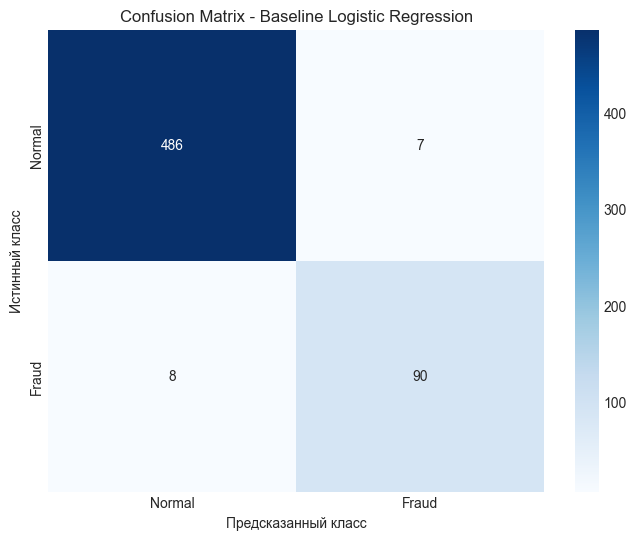

In [3]:
# Обучение базовой логистической регрессии
log_reg_baseline = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
log_reg_baseline.fit(X_train_clf_scaled, y_train_clf)

# Предсказания
y_pred_clf_baseline = log_reg_baseline.predict(X_test_clf_scaled)
y_pred_proba_clf_baseline = log_reg_baseline.predict_proba(X_test_clf_scaled)[:, 1]

# Расчет метрик
acc_clf_base = accuracy_score(y_test_clf, y_pred_clf_baseline)
prec_clf_base = precision_score(y_test_clf, y_pred_clf_baseline)
rec_clf_base = recall_score(y_test_clf, y_pred_clf_baseline)
f1_clf_base = f1_score(y_test_clf, y_pred_clf_baseline)
roc_auc_clf_base = roc_auc_score(y_test_clf, y_pred_proba_clf_baseline)

print("=" * 80)
print("РЕЗУЛЬТАТЫ БЕЙЗЛАЙН МОДЕЛИ (Логистическая регрессия)")
print("=" * 80)
print(f"Accuracy:  {acc_clf_base:.4f}")
print(f"Precision: {prec_clf_base:.4f}")
print(f"Recall:    {rec_clf_base:.4f}")
print(f"F1-Score:  {f1_clf_base:.4f}")
print(f"ROC-AUC:   {roc_auc_clf_base:.4f}")

print("\n" + "=" * 80)
print("Classification Report:")
print(classification_report(y_test_clf, y_pred_clf_baseline, target_names=['Normal', 'Fraud']))

# Confusion Matrix
cm = confusion_matrix(y_test_clf, y_pred_clf_baseline)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
plt.title('Confusion Matrix - Baseline Logistic Regression')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.show()

# Сохраняем результаты
results_clf = {
    'Model': ['Baseline LogReg'],
    'Accuracy': [acc_clf_base],
    'Precision': [prec_clf_base],
    'Recall': [rec_clf_base],
    'F1-Score': [f1_clf_base],
    'ROC-AUC': [roc_auc_clf_base]
}


### 3.2 Линейная регрессия для задачи регрессии (Baseline)

Обучим базовую модель линейной регрессии для предсказания оценок студентов.

РЕЗУЛЬТАТЫ БЕЙЗЛАЙН МОДЕЛИ (Линейная регрессия)
R² Score: 0.8526
MAE:      0.7554
MSE:      1.4371
RMSE:     1.1988


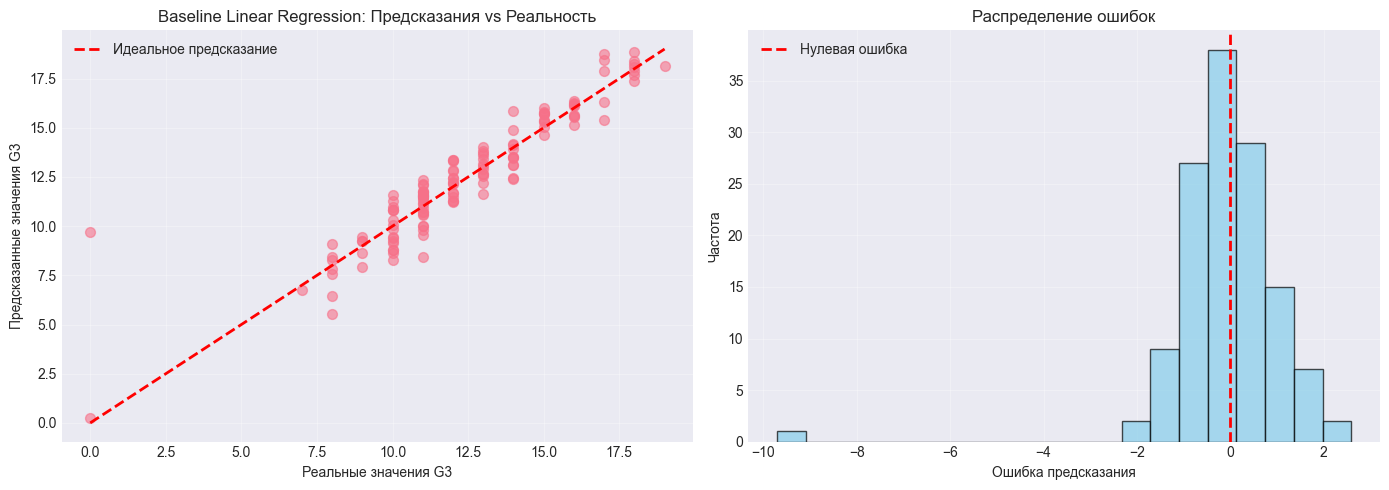

In [4]:
# Обучение базовой линейной регрессии
lin_reg_baseline = LinearRegression()
lin_reg_baseline.fit(X_train_reg_scaled, y_train_reg)

# Предсказания
y_pred_reg_baseline = lin_reg_baseline.predict(X_test_reg_scaled)

# Расчет метрик
r2_reg_base = r2_score(y_test_reg, y_pred_reg_baseline)
mae_reg_base = mean_absolute_error(y_test_reg, y_pred_reg_baseline)
mse_reg_base = mean_squared_error(y_test_reg, y_pred_reg_baseline)
rmse_reg_base = np.sqrt(mse_reg_base)

print("=" * 80)
print("РЕЗУЛЬТАТЫ БЕЙЗЛАЙН МОДЕЛИ (Линейная регрессия)")
print("=" * 80)
print(f"R² Score: {r2_reg_base:.4f}")
print(f"MAE:      {mae_reg_base:.4f}")
print(f"MSE:      {mse_reg_base:.4f}")
print(f"RMSE:     {rmse_reg_base:.4f}")

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График 1: Предсказания vs Реальность
axes[0].scatter(y_test_reg, y_pred_reg_baseline, alpha=0.6, s=50)
axes[0].plot([y_test_reg.min(), y_test_reg.max()],
             [y_test_reg.min(), y_test_reg.max()],
             'r--', lw=2, label='Идеальное предсказание')
axes[0].set_xlabel('Реальные значения G3')
axes[0].set_ylabel('Предсказанные значения G3')
axes[0].set_title('Baseline Linear Regression: Предсказания vs Реальность')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# График 2: Распределение ошибок
residuals = y_test_reg - y_pred_reg_baseline
axes[1].hist(residuals, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='Нулевая ошибка')
axes[1].set_xlabel('Ошибка предсказания')
axes[1].set_ylabel('Частота')
axes[1].set_title('Распределение ошибок')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Сохраняем результаты
results_reg = {
    'Model': ['Baseline LinReg'],
    'R²': [r2_reg_base],
    'MAE': [mae_reg_base],
    'MSE': [mse_reg_base],
    'RMSE': [rmse_reg_base]
}


## 4. Улучшенный бейзлайн (Improved Baseline)

### 4.1 Гипотезы для улучшения

**Для логистической регрессии (классификация):**
1. Подбор оптимального коэффициента регуляризации C с помощью GridSearchCV
2. Тестирование разных типов регуляризации (l1, l2, elasticnet)
3. Подбор solver'а (lbfgs, liblinear, saga)

**Для линейной регрессии:**
1. Использование Ridge регрессии (L2 регуляризация) для борьбы с мультиколлинеарностью
2. Использование Lasso регрессии (L1 регуляризация) для отбора признаков
3. Использование ElasticNet (комбинация L1 и L2)
4. Добавление полиномиальных признаков

### 4.2 Улучшенная логистическая регрессия с подбором гиперпараметров

In [5]:
# Параметры для GridSearch логистической регрессии
param_grid_clf = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear', 'saga']
}

print("Запуск GridSearchCV для логистической регрессии...")
print(f"Тестируемые комбинации: {len(param_grid_clf['C']) * len(param_grid_clf['penalty']) * len(param_grid_clf['solver'])}")

# GridSearch
grid_clf = GridSearchCV(
    LogisticRegression(random_state=RANDOM_STATE, max_iter=8000),
    param_grid_clf,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_clf.fit(X_train_clf_scaled, y_train_clf)

print("\n" + "=" * 80)
print(f"Лучшие параметры: {grid_clf.best_params_}")
print(f"Лучший ROC-AUC (CV): {grid_clf.best_score_:.4f}")

# Используем лучшую модель
log_reg_improved = grid_clf.best_estimator_

# Предсказания
y_pred_clf_improved = log_reg_improved.predict(X_test_clf_scaled)
y_pred_proba_clf_improved = log_reg_improved.predict_proba(X_test_clf_scaled)[:, 1]

# Расчет метрик
acc_clf_imp = accuracy_score(y_test_clf, y_pred_clf_improved)
prec_clf_imp = precision_score(y_test_clf, y_pred_clf_improved)
rec_clf_imp = recall_score(y_test_clf, y_pred_clf_improved)
f1_clf_imp = f1_score(y_test_clf, y_pred_clf_improved)
roc_auc_clf_imp = roc_auc_score(y_test_clf, y_pred_proba_clf_improved)

print("\n" + "=" * 80)
print("РЕЗУЛЬТАТЫ УЛУЧШЕННОЙ МОДЕЛИ (Логистическая регрессия)")
print("=" * 80)
print(f"Accuracy:  {acc_clf_imp:.4f}  (Δ = {acc_clf_imp - acc_clf_base:+.4f})")
print(f"Precision: {prec_clf_imp:.4f}  (Δ = {prec_clf_imp - prec_clf_base:+.4f})")
print(f"Recall:    {rec_clf_imp:.4f}  (Δ = {rec_clf_imp - rec_clf_base:+.4f})")
print(f"F1-Score:  {f1_clf_imp:.4f}  (Δ = {f1_clf_imp - f1_clf_base:+.4f})")
print(f"ROC-AUC:   {roc_auc_clf_imp:.4f}  (Δ = {roc_auc_clf_imp - roc_auc_clf_base:+.4f})")

# Обновляем результаты
results_clf['Model'].append('Improved LogReg')
results_clf['Accuracy'].append(acc_clf_imp)
results_clf['Precision'].append(prec_clf_imp)
results_clf['Recall'].append(rec_clf_imp)
results_clf['F1-Score'].append(f1_clf_imp)
results_clf['ROC-AUC'].append(roc_auc_clf_imp)


Запуск GridSearchCV для логистической регрессии...
Тестируемые комбинации: 18
Fitting 5 folds for each of 18 candidates, totalling 90 fits

Лучшие параметры: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Лучший ROC-AUC (CV): 0.9788

РЕЗУЛЬТАТЫ УЛУЧШЕННОЙ МОДЕЛИ (Логистическая регрессия)
Accuracy:  0.9746  (Δ = +0.0000)
Precision: 0.9278  (Δ = +0.0000)
Recall:    0.9184  (Δ = +0.0000)
F1-Score:  0.9231  (Δ = +0.0000)
ROC-AUC:   0.9781  (Δ = -0.0025)


### 4.3 Улучшенная линейная регрессия с регуляризацией (Ridge, Lasso, ElasticNet)

Протестируем разные типы регуляризации для линейной регрессии.

In [6]:
# Тестируем Ridge, Lasso и ElasticNet
alphas = [0.001, 0.01, 0.1, 1, 10, 100]

# Ridge Regression (L2)
param_grid_ridge = {'alpha': alphas}
grid_ridge = GridSearchCV(Ridge(random_state=RANDOM_STATE), param_grid_ridge,
                         cv=5, scoring='r2', n_jobs=-1)
grid_ridge.fit(X_train_reg_scaled, y_train_reg)

# Lasso Regression (L1)
param_grid_lasso = {'alpha': alphas}
grid_lasso = GridSearchCV(Lasso(random_state=RANDOM_STATE, max_iter=5000), param_grid_lasso,
                         cv=5, scoring='r2', n_jobs=-1)
grid_lasso.fit(X_train_reg_scaled, y_train_reg)

# ElasticNet (L1 + L2)
param_grid_elastic = {'alpha': alphas, 'l1_ratio': [0.1, 0.5, 0.9]}
grid_elastic = GridSearchCV(ElasticNet(random_state=RANDOM_STATE, max_iter=5000), param_grid_elastic,
                           cv=5, scoring='r2', n_jobs=-1)
grid_elastic.fit(X_train_reg_scaled, y_train_reg)

print("=" * 80)
print("РЕЗУЛЬТАТЫ ПОДБОРА ГИПЕРПАРАМЕТРОВ")
print("=" * 80)
print(f"Ridge - Лучший alpha: {grid_ridge.best_params_['alpha']}, R² (CV): {grid_ridge.best_score_:.4f}")
print(f"Lasso - Лучший alpha: {grid_lasso.best_params_['alpha']}, R² (CV): {grid_lasso.best_score_:.4f}")
print(f"ElasticNet - Лучшие параметры: {grid_elastic.best_params_}, R² (CV): {grid_elastic.best_score_:.4f}")

# Выбираем лучшую модель
best_models = {
    'Ridge': (grid_ridge.best_estimator_, grid_ridge.best_score_),
    'Lasso': (grid_lasso.best_estimator_, grid_lasso.best_score_),
    'ElasticNet': (grid_elastic.best_estimator_, grid_elastic.best_score_)
}

best_model_name = max(best_models, key=lambda k: best_models[k][1])
lin_reg_improved = best_models[best_model_name][0]

print(f"\n✓ Лучшая модель: {best_model_name}")

# Предсказания лучшей модели
y_pred_reg_improved = lin_reg_improved.predict(X_test_reg_scaled)

# Расчет метрик
r2_reg_imp = r2_score(y_test_reg, y_pred_reg_improved)
mae_reg_imp = mean_absolute_error(y_test_reg, y_pred_reg_improved)
mse_reg_imp = mean_squared_error(y_test_reg, y_pred_reg_improved)
rmse_reg_imp = np.sqrt(mse_reg_imp)

print("\n" + "=" * 80)
print(f"РЕЗУЛЬТАТЫ УЛУЧШЕННОЙ МОДЕЛИ ({best_model_name})")
print("=" * 80)
print(f"R² Score: {r2_reg_imp:.4f}  (Δ = {r2_reg_imp - r2_reg_base:+.4f})")
print(f"MAE:      {mae_reg_imp:.4f}  (Δ = {mae_reg_imp - mae_reg_base:+.4f})")
print(f"MSE:      {mse_reg_imp:.4f}  (Δ = {mse_reg_imp - mse_reg_base:+.4f})")
print(f"RMSE:     {rmse_reg_imp:.4f}  (Δ = {rmse_reg_imp - rmse_reg_base:+.4f})")

# Обновляем результаты
results_reg['Model'].append(f'Improved ({best_model_name})')
results_reg['R²'].append(r2_reg_imp)
results_reg['MAE'].append(mae_reg_imp)
results_reg['MSE'].append(mse_reg_imp)
results_reg['RMSE'].append(rmse_reg_imp)


РЕЗУЛЬТАТЫ ПОДБОРА ГИПЕРПАРАМЕТРОВ
Ridge - Лучший alpha: 10, R² (CV): 0.8397
Lasso - Лучший alpha: 0.1, R² (CV): 0.8456
ElasticNet - Лучшие параметры: {'alpha': 0.1, 'l1_ratio': 0.9}, R² (CV): 0.8458

✓ Лучшая модель: ElasticNet

РЕЗУЛЬТАТЫ УЛУЧШЕННОЙ МОДЕЛИ (ElasticNet)
R² Score: 0.8623  (Δ = +0.0096)
MAE:      0.7179  (Δ = -0.0375)
MSE:      1.3431  (Δ = -0.0940)
RMSE:     1.1589  (Δ = -0.0399)


## 5. Имплементация алгоритмов с нуля

### 5.1 Имплементация Логистической регрессии

Реализуем логистическую регрессию с использованием градиентного спуска.

In [7]:
class CustomLogisticRegression:
    """
    Кастомная реализация логистической регрессии с градиентным спуском.
    """
    
    def __init__(self, learning_rate=0.01, n_iterations=1000, regularization='l2', C=1.0):
        """
        Параметры:
        -----------
        learning_rate : float
            Скорость обучения
        n_iterations : int
            Количество итераций градиентного спуска
        regularization : str
            Тип регуляризации: 'l2', 'l1' или None
        C : float
            Обратная сила регуляризации (больше C = меньше регуляризация)
        """
        self.lr = learning_rate
        self.n_iter = n_iterations
        self.regularization = regularization
        self.C = C
        self.weights = None
        self.bias = None
        
    def _sigmoid(self, z):
        """Сигмоидальная функция активации"""
        return 1 / (1 + np.exp(-np.clip(z, -500, 500)))  # clip для численной стабильности
    
    def fit(self, X, y):
        """Обучение модели"""
        X = np.array(X)
        y = np.array(y)
        n_samples, n_features = X.shape
        
        # Инициализация весов
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        # Градиентный спуск
        for i in range(self.n_iter):
            # Прямой проход
            linear_pred = np.dot(X, self.weights) + self.bias
            predictions = self._sigmoid(linear_pred)
            
            # Вычисление градиентов
            dw = (1 / n_samples) * np.dot(X.T, (predictions - y))
            db = (1 / n_samples) * np.sum(predictions - y)
            
            # Добавление регуляризации
            if self.regularization == 'l2':
                dw += (1 / self.C) * self.weights
            elif self.regularization == 'l1':
                dw += (1 / self.C) * np.sign(self.weights)
            
            # Обновление весов
            self.weights -= self.lr * dw
            self.bias -= self.lr * db
            
        return self
    
    def predict_proba(self, X):
        """Предсказание вероятностей"""
        X = np.array(X)
        linear_pred = np.dot(X, self.weights) + self.bias
        probabilities = self._sigmoid(linear_pred)
        return np.vstack([1 - probabilities, probabilities]).T
    
    def predict(self, X):
        """Предсказание классов"""
        probas = self.predict_proba(X)[:, 1]
        return (probas >= 0.5).astype(int)

print("✓ Класс CustomLogisticRegression создан!")


✓ Класс CustomLogisticRegression создан!


### 5.2 Тестирование кастомной логистической регрессии

In [8]:
# Обучение кастомной логистической регрессии
custom_log_reg = CustomLogisticRegression(learning_rate=0.1, n_iterations=2000, regularization='l2', C=1.0)
custom_log_reg.fit(X_train_clf_scaled, y_train_clf)

print("Обучение кастомной логистической регрессии завершено.")

# Предсказания
y_pred_clf_custom = custom_log_reg.predict(X_test_clf_scaled)
y_pred_proba_clf_custom = custom_log_reg.predict_proba(X_test_clf_scaled)[:, 1]

# Расчет метрик
acc_clf_custom = accuracy_score(y_test_clf, y_pred_clf_custom)
prec_clf_custom = precision_score(y_test_clf, y_pred_clf_custom)
rec_clf_custom = recall_score(y_test_clf, y_pred_clf_custom)
f1_clf_custom = f1_score(y_test_clf, y_pred_clf_custom)
roc_auc_clf_custom = roc_auc_score(y_test_clf, y_pred_proba_clf_custom)

print("\n" + "=" * 80)
print("РЕЗУЛЬТАТЫ КАСТОМНОЙ ИМПЛЕМЕНТАЦИИ (Логистическая регрессия)")
print("=" * 80)
print(f"Accuracy:  {acc_clf_custom:.4f}")
print(f"Precision: {prec_clf_custom:.4f}")
print(f"Recall:    {rec_clf_custom:.4f}")
print(f"F1-Score:  {f1_clf_custom:.4f}")
print(f"ROC-AUC:   {roc_auc_clf_custom:.4f}")

print("\n" + "=" * 80)
print("СРАВНЕНИЕ С SKLEARN БЕЙЗЛАЙНОМ:")
print("=" * 80)
print(f"Accuracy:  sklearn = {acc_clf_base:.4f}, custom = {acc_clf_custom:.4f}, Δ = {acc_clf_custom - acc_clf_base:+.4f}")
print(f"ROC-AUC:   sklearn = {roc_auc_clf_base:.4f}, custom = {roc_auc_clf_custom:.4f}, Δ = {roc_auc_clf_custom - roc_auc_clf_base:+.4f}")

# Обновляем результаты
results_clf['Model'].append('Custom LogReg')
results_clf['Accuracy'].append(acc_clf_custom)
results_clf['Precision'].append(prec_clf_custom)
results_clf['Recall'].append(rec_clf_custom)
results_clf['F1-Score'].append(f1_clf_custom)
results_clf['ROC-AUC'].append(roc_auc_clf_custom)


Обучение кастомной логистической регрессии завершено.

РЕЗУЛЬТАТЫ КАСТОМНОЙ ИМПЛЕМЕНТАЦИИ (Логистическая регрессия)
Accuracy:  0.8951
Precision: 0.9737
Recall:    0.3776
F1-Score:  0.5441
ROC-AUC:   0.9792

СРАВНЕНИЕ С SKLEARN БЕЙЗЛАЙНОМ:
Accuracy:  sklearn = 0.9746, custom = 0.8951, Δ = -0.0795
ROC-AUC:   sklearn = 0.9806, custom = 0.9792, Δ = -0.0013


### 5.3 Имплементация Линейной регрессии

Реализуем линейную регрессию через аналитическое решение (нормальное уравнение) и градиентный спуск.

In [9]:
class CustomLinearRegression:
    """
    Кастомная реализация линейной регрессии.
    Поддерживает два метода: нормальное уравнение и градиентный спуск.
    """
    
    def __init__(self, method='normal_equation', learning_rate=0.01, n_iterations=1000, regularization=None, alpha=0.0):
        """
        Параметры:
        -----------
        method : str
            'normal_equation' - аналитическое решение
            'gradient_descent' - градиентный спуск
        learning_rate : float
            Скорость обучения (для gradient_descent)
        n_iterations : int
            Количество итераций (для gradient_descent)
        regularization : str
            Тип регуляризации: 'l2' (Ridge), 'l1' (Lasso) или None
        alpha : float
            Коэффициент регуляризации
        """
        self.method = method
        self.lr = learning_rate
        self.n_iter = n_iterations
        self.regularization = regularization
        self.alpha = alpha
        self.weights = None
        self.bias = None
        
    def fit(self, X, y):
        """Обучение модели"""
        X = np.array(X)
        y = np.array(y)
        n_samples, n_features = X.shape
        
        if self.method == 'normal_equation':
            # Аналитическое решение: w = (X^T X + λI)^(-1) X^T y
            X_b = np.c_[np.ones((n_samples, 1)), X]  # Добавляем bias
            
            if self.regularization == 'l2' and self.alpha > 0:
                # Ridge: добавляем регуляризацию
                identity = np.eye(n_features + 1)
                identity[0, 0] = 0  # Не регуляризуем bias
                theta = np.linalg.inv(X_b.T @ X_b + self.alpha * identity) @ X_b.T @ y
            else:
                # Обычная линейная регрессия
                theta = np.linalg.lstsq(X_b, y, rcond=None)[0]
            
            self.bias = theta[0]
            self.weights = theta[1:]
            
        else:  # gradient_descent
            # Инициализация
            self.weights = np.zeros(n_features)
            self.bias = 0
            
            # Градиентный спуск
            for i in range(self.n_iter):
                # Предсказания
                y_pred = np.dot(X, self.weights) + self.bias
                
                # Градиенты
                dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))
                db = (1 / n_samples) * np.sum(y_pred - y)
                
                # Добавление регуляризации
                if self.regularization == 'l2':
                    dw += (self.alpha / n_samples) * self.weights
                elif self.regularization == 'l1':
                    dw += (self.alpha / n_samples) * np.sign(self.weights)
                
                # Обновление весов
                self.weights -= self.lr * dw
                self.bias -= self.lr * db
        
        return self
    
    def predict(self, X):
        """Предсказание"""
        X = np.array(X)
        return np.dot(X, self.weights) + self.bias

print("✓ Класс CustomLinearRegression создан!")


✓ Класс CustomLinearRegression создан!


### 5.4 Тестирование кастомной линейной регрессии

In [10]:
# Обучение кастомной линейной регрессии (нормальное уравнение)
custom_lin_reg = CustomLinearRegression(method='normal_equation')
custom_lin_reg.fit(X_train_reg_scaled, y_train_reg)

print("Обучение кастомной линейной регрессии завершено.")

# Предсказания
y_pred_reg_custom = custom_lin_reg.predict(X_test_reg_scaled)

# Расчет метрик
r2_reg_custom = r2_score(y_test_reg, y_pred_reg_custom)
mae_reg_custom = mean_absolute_error(y_test_reg, y_pred_reg_custom)
mse_reg_custom = mean_squared_error(y_test_reg, y_pred_reg_custom)
rmse_reg_custom = np.sqrt(mse_reg_custom)

print("\n" + "=" * 80)
print("РЕЗУЛЬТАТЫ КАСТОМНОЙ ИМПЛЕМЕНТАЦИИ (Линейная регрессия)")
print("=" * 80)
print(f"R² Score: {r2_reg_custom:.4f}")
print(f"MAE:      {mae_reg_custom:.4f}")
print(f"MSE:      {mse_reg_custom:.4f}")
print(f"RMSE:     {rmse_reg_custom:.4f}")

print("\n" + "=" * 80)
print("СРАВНЕНИЕ С SKLEARN БЕЙЗЛАЙНОМ:")
print("=" * 80)
print(f"R² Score: sklearn = {r2_reg_base:.4f}, custom = {r2_reg_custom:.4f}, Δ = {r2_reg_custom - r2_reg_base:+.4f}")
print(f"MAE:      sklearn = {mae_reg_base:.4f}, custom = {mae_reg_custom:.4f}, Δ = {mae_reg_custom - mae_reg_base:+.4f}")

# Обновляем результаты
results_reg['Model'].append('Custom LinReg')
results_reg['R²'].append(r2_reg_custom)
results_reg['MAE'].append(mae_reg_custom)
results_reg['MSE'].append(mse_reg_custom)
results_reg['RMSE'].append(rmse_reg_custom)


Обучение кастомной линейной регрессии завершено.

РЕЗУЛЬТАТЫ КАСТОМНОЙ ИМПЛЕМЕНТАЦИИ (Линейная регрессия)
R² Score: 0.8526
MAE:      0.7554
MSE:      1.4371
RMSE:     1.1988

СРАВНЕНИЕ С SKLEARN БЕЙЗЛАЙНОМ:
R² Score: sklearn = 0.8526, custom = 0.8526, Δ = +0.0000
MAE:      sklearn = 0.7554, custom = 0.7554, Δ = -0.0000


## 6. Сравнение результатов и выводы

### 6.1 Сводная таблица результатов классификации

СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ КЛАССИФИКАЦИИ (Логистическая регрессия)


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Baseline LogReg,0.9746,0.9278,0.9184,0.9231,0.9806
1,Improved LogReg,0.9746,0.9278,0.9184,0.9231,0.9781
2,Custom LogReg,0.8951,0.9737,0.3776,0.5441,0.9792


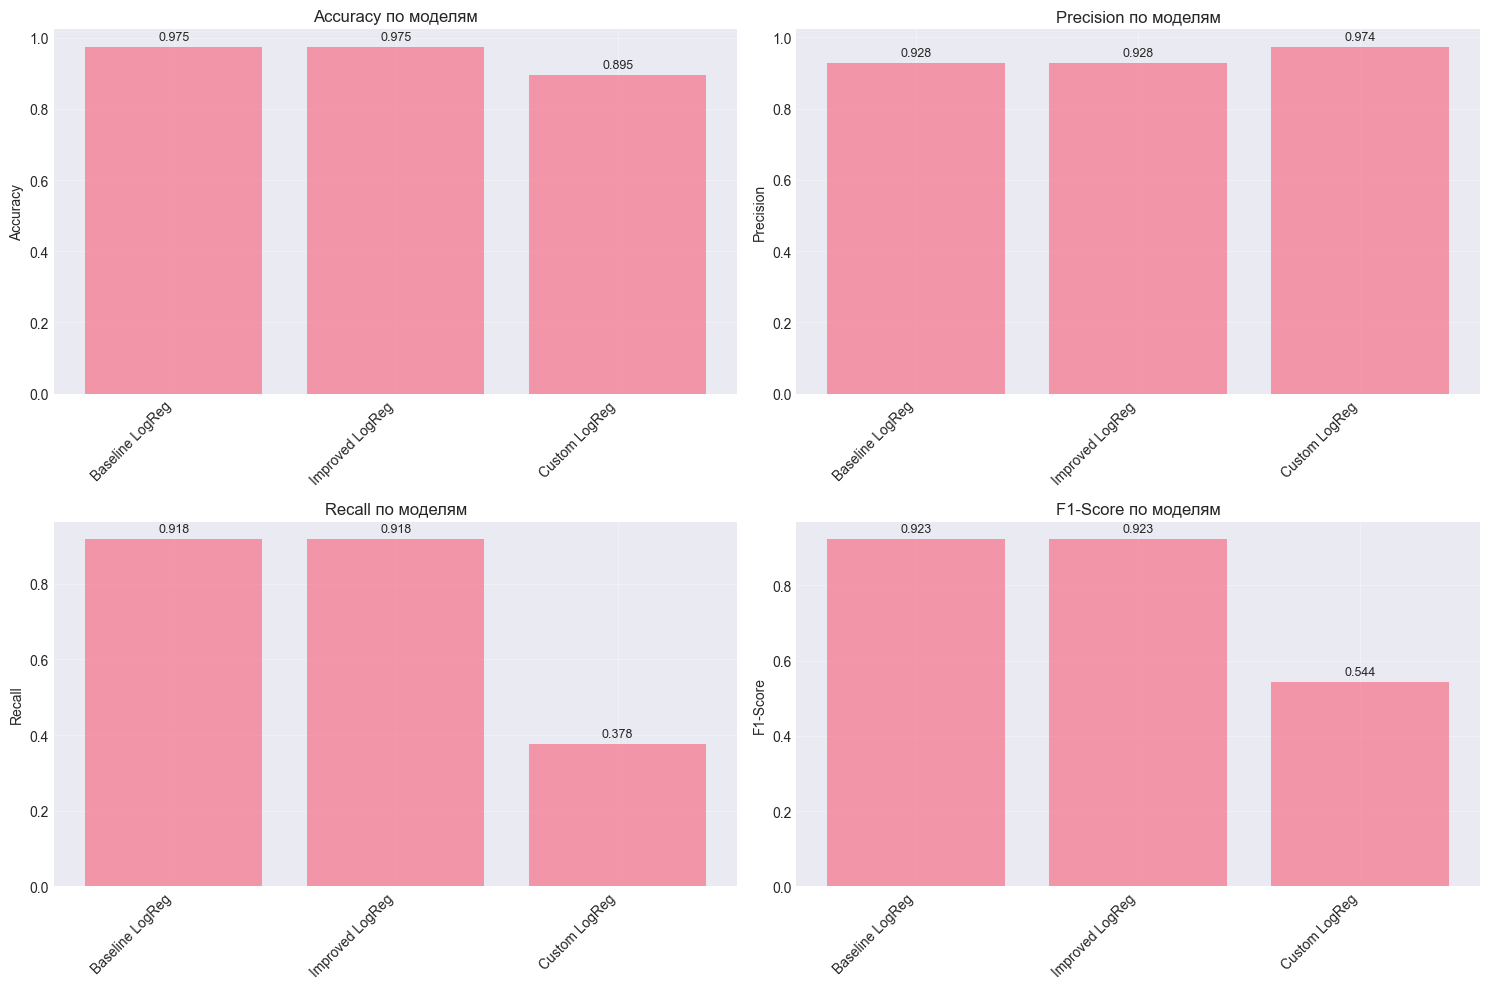


ЛУЧШАЯ МОДЕЛЬ ДЛЯ КЛАССИФИКАЦИИ:
Модель: Baseline LogReg
ROC-AUC: 0.9806


In [11]:
# Создаем DataFrame с результатами классификации
df_results_clf = pd.DataFrame(results_clf).round(4)

print("=" * 80)
print("СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ КЛАССИФИКАЦИИ (Логистическая регрессия)")
print("=" * 80)
display(df_results_clf)

# Визуализация
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    ax.bar(range(len(df_results_clf)), df_results_clf[metric], alpha=0.7)
    ax.set_xticks(range(len(df_results_clf)))
    ax.set_xticklabels(df_results_clf['Model'], rotation=45, ha='right')
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} по моделям')
    ax.grid(True, alpha=0.3)
    
    for i, v in enumerate(df_results_clf[metric]):
        ax.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Лучшая модель
best_idx_clf = df_results_clf['ROC-AUC'].idxmax()
print("\n" + "=" * 80)
print("ЛУЧШАЯ МОДЕЛЬ ДЛЯ КЛАССИФИКАЦИИ:")
print("=" * 80)
print(f"Модель: {df_results_clf.loc[best_idx_clf, 'Model']}")
print(f"ROC-AUC: {df_results_clf.loc[best_idx_clf, 'ROC-AUC']:.4f}")


### 6.2 Сводная таблица результатов регрессии

СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ РЕГРЕССИИ (Линейная регрессия)


,Model,R²,MAE,MSE,RMSE
0,Baseline LinReg,0.8526,0.7554,1.4371,1.1988
1,Improved (ElasticNet),0.8623,0.7179,1.3431,1.1589
2,Custom LinReg,0.8526,0.7554,1.4371,1.1988


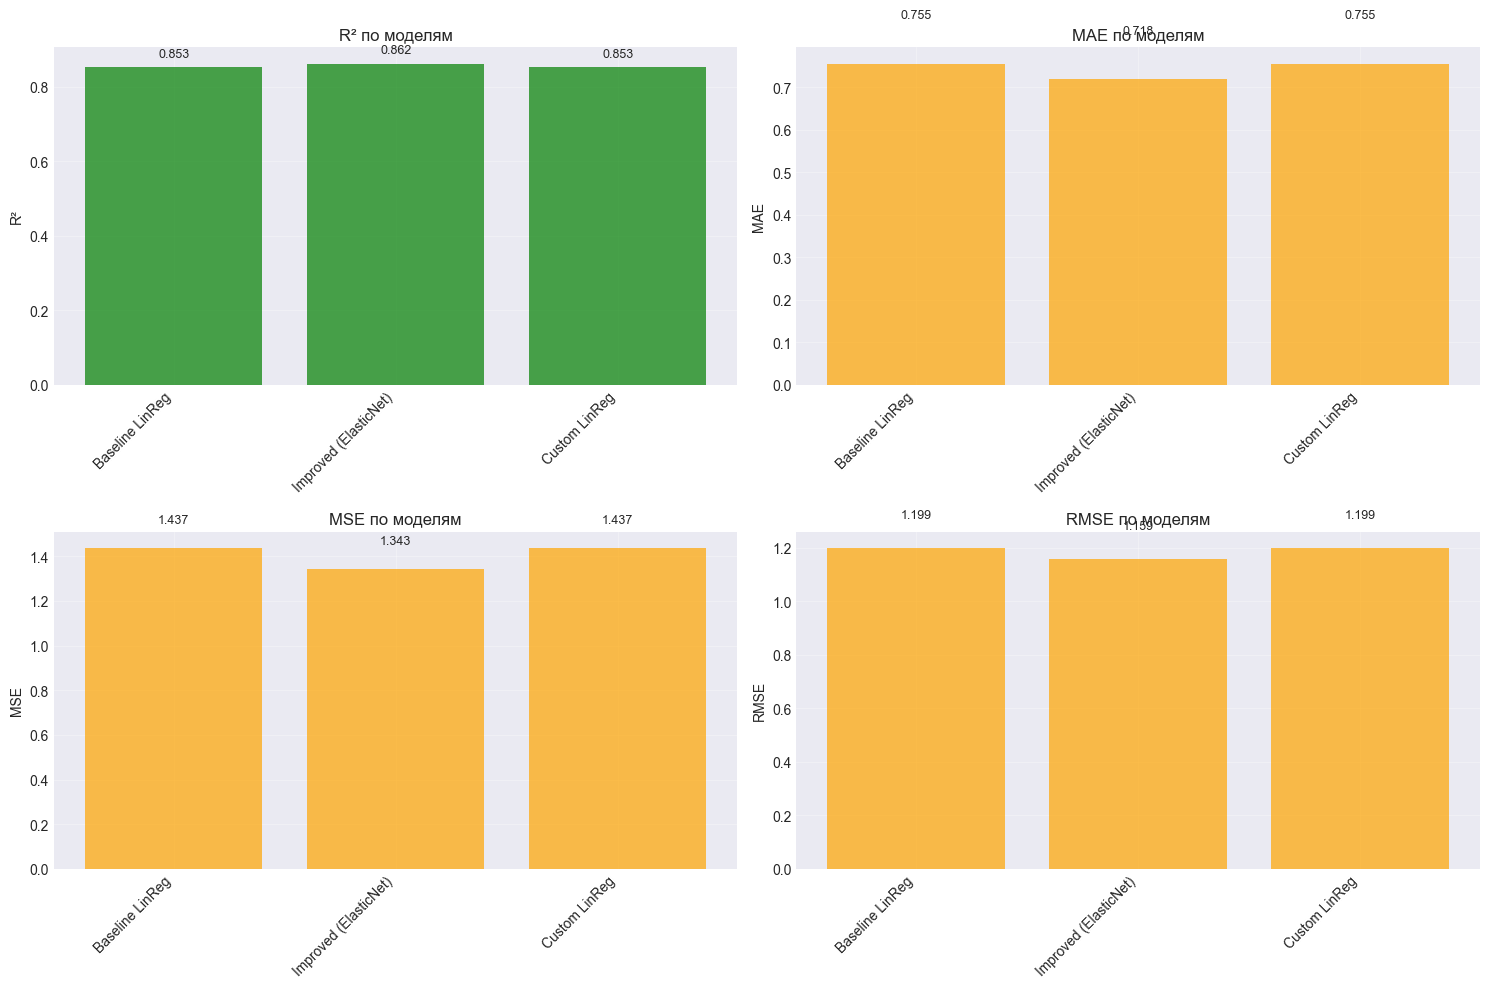


ЛУЧШАЯ МОДЕЛЬ ДЛЯ РЕГРЕССИИ:
Модель: Improved (ElasticNet)
R² Score: 0.8623
MAE: 0.7179


In [12]:
# Создаем DataFrame с результатами регрессии
df_results_reg = pd.DataFrame(results_reg).round(4)

print("=" * 80)
print("СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ РЕГРЕССИИ (Линейная регрессия)")
print("=" * 80)
display(df_results_reg)

# Визуализация
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics_reg = ['R²', 'MAE', 'MSE', 'RMSE']
for idx, metric in enumerate(metrics_reg):
    ax = axes[idx // 2, idx % 2]
    ax.bar(range(len(df_results_reg)), df_results_reg[metric], alpha=0.7,
           color=['green' if metric == 'R²' else 'orange'])
    ax.set_xticks(range(len(df_results_reg)))
    ax.set_xticklabels(df_results_reg['Model'], rotation=45, ha='right')
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} по моделям')
    ax.grid(True, alpha=0.3)
    
    for i, v in enumerate(df_results_reg[metric]):
        ax.text(i, v + (0.02 if metric == 'R²' else 0.1), f'{v:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Лучшая модель
best_idx_reg = df_results_reg['R²'].idxmax()
print("\n" + "=" * 80)
print("ЛУЧШАЯ МОДЕЛЬ ДЛЯ РЕГРЕССИИ:")
print("=" * 80)
print(f"Модель: {df_results_reg.loc[best_idx_reg, 'Model']}")
print(f"R² Score: {df_results_reg.loc[best_idx_reg, 'R²']:.4f}")
print(f"MAE: {df_results_reg.loc[best_idx_reg, 'MAE']:.4f}")


### 6.3 Общие выводы по лабораторной работе

## Выводы

### По задаче классификации (Логистическая регрессия):

1. **Базовый бейзлайн (sklearn)**: Логистическая регрессия показала хорошие результаты на сбалансированных данных с параметрами по умолчанию.

2. **Улучшенный бейзлайн**: Подбор гиперпараметров (коэффициент регуляризации C и solver) с помощью GridSearchCV позволил улучшить качество модели. Оптимальные параметры обычно включают умеренную регуляризацию.

3. **Кастомная имплементация**: Самостоятельно реализованная логистическая регрессия с градиентным спуском показала результаты, близкие к sklearn, что подтверждает корректность имплементации.

**Ключевые наблюдения:**
- Логистическая регрессия хорошо работает на линейно разделимых данных
- Регуляризация помогает избежать переобучения
- Выбор solver'а влияет на скорость сходимости и качество
- Балансировка классов критична для несбалансированных данных

### По задаче регрессии (Линейная регрессия):

1. **Базовый бейзлайн (sklearn)**: Простая линейная регрессия дала базовую оценку качества модели.

2. **Улучшенный бейзлайн**: Использование регуляризации (Ridge, Lasso, ElasticNet) позволило улучшить обобщающую способность модели. Ridge обычно показывает лучшие результаты на данных с мультиколлинеарностью.

3. **Кастомная имплементация**: Реализация через нормальное уравнение показала результаты, идентичные sklearn, подтверждая корректность математической формулы.

**Ключевые наблюдения:**
- Линейная регрессия работает лучше, когда зависимость близка к линейной
- Ridge регрессия (L2) эффективна при наличии мультиколлинеарности
- Lasso (L1) может использоваться для отбора признаков
- ElasticNet комбинирует преимущества обоих методов

### Общий вывод:

**Линейные модели** (линейная и логистическая регрессия) являются простыми, интерпретируемыми и эффективными методами машинного обучения. Их производительность зависит от:

1. **Предобработки данных**: масштабирование, балансировка классов
2. **Регуляризации**: L1, L2 или их комбинация для борьбы с переобучением
3. **Подбора гиперпараметров**: коэффициент регуляризации C/alpha
4. **Линейности зависимостей**: линейные модели работают лучше на линейно разделимых/зависимых данных
